In [1]:
#######################################################################
# This script was written by Nana Owusu, it is meant to perform T1rho #
# estimation from DICOM image files to NIFTI image files.             #
#######################################################################

import os, sys, re, fnmatch, tkinter
import numpy as np
import nibabel as nib
import pydicom as pydcm
import math as m
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from tkinter import filedialog

## Section for sorting DICOM files

In [2]:
# Function for picking DICOM file order
def dcmItemize(convention,text):
    # Regular expressions for naming convention of scanners #
    if '3Tsem' in convention:
        pattern = '\w+\.\w+\.\w+\.(\d+)\.(\d+)\.\d+\.\d+\.\d+\.\d+\.dcm'
    elif '3Tge' in convention:
         pattern = '\w+\.\w+\.\w+\.\d+\.\d+\.\d+\.\d+\-(\d+)\-(\d+)\-\w+\.dcm'
    elif '7Th' in convention:
         pattern = '\w+\.\w+\.\w+\.(\d+)\.(\d+)\.\d+\.\d+\-\d+\-\d+\-\w+\.dcm'
    elif '7Ta' in convention:
         pattern = '\w+\.\w+\.\w+\.(\d+)\.\d+\.\d+\.\d+\-\d+\-(\d+)\-\w+\.dcm'
    
    token = re.search(pattern, text)
    return int(token.group(1)), int(token.group(2)) if token else '&'

def dcmSort(imOrder,fileList):
    idxNList = zip(imOrder, fileList)
    sortedList = [x for x in idxNList]
    sortedList.sort(key=lambda sortedList:sortedList[0])
    return list(sortedList)

def uigetdir(tsl2Disp):
    # initialize tkinter object
    main_win = tkinter.Tk()
    main_win.geometry("500x500")
    
    # starting from user's Documents folder 
    main_win.sourceFolder =  \
    filedialog.askdirectory(parent=main_win, initialdir= "/Users/nowusu/scripts/",\
                            title='Please select TSL {0} directory'.format(str(tsl2Disp)))

    # run the GUI program
    main_win.mainloop()
    return main_win.sourceFolder

#if len(sys.argv) != 5:
#    sys.exit('Usage: python t1rProcessing.py <spinLockImLocation> minTSL maxTSL numTSL')

#print 'Script Name: ', sys.argv[0]
#print 'Input File: ', sys.argv[1]
#print 'Minimum TSL: ', sys.argv[2]
#print 'Maximum TSL: ', sys.argv[3]
#print 'TSL Quantity: ', sys.argv[4]

#min_TSL = sys.argv[2]
#max_TSL = sys.argv[3]
#tslPlayed = sys.argv[4]

# Call GUI window for selection of DICOM directories
# for storage of their full paths
TSLs = [5,80]
dcmList = []
for i in range(len(TSLs)):
    dcmList.append(uigetdir(TSLs[i]))

In [3]:
# Create placeholder and fill list for image in acquisition
tempList = []
dcmFiles = []
for j in range(len(dcmList)):
    # provide the absolute path of the current directory
    imLoc = dcmList[j] + '/'
    # list all files in the DICOM directory
    dirList = os.listdir(imLoc)
    # store only DICOM files
    filesInDir = fnmatch.filter(dirList,'*.dcm')

    for i in range(len(filesInDir)):
        tempList.append(dcmItemize('3Tge', filesInDir[i]))
        dcmFiles.append(filesInDir[i])

imsAcquired = len(tempList)
seriesQuant = 0
for j in range(len(tempList)-1):
    order = tempList[0][0]
    seriesQuant = 1
    if tempList[j+1][0] > order:
        seriesQuant += 1

sortedFiles = dcmSort(tempList, dcmFiles)

# Create multidimentional list for storted abs. paths
# DICOM images
numOfIms = m.floor(imsAcquired/seriesQuant)
dcmFullPath = [[] for i in range(seriesQuant)]
x = 0
while x != seriesQuant:
    for i,j in sortedFiles:
        #fill array with dcm abs. paths
        dcmFullPath[:][x].append(dcmList[x] + '/'+ j)
        if i[1] == numOfIms:
            x += 1
            continue
    
# Garbage collection of unused variables
del dcmList, dirList, tempList, dcmFiles

## Load files

In [4]:
def sliceSorter(image_data,seriesCount,vol,seriesFiles):
    if "NumberOfTemporalPositions" not in image_data:
        t = 0
        while t != seriesCount:
            for i,j in enumerate(seriesFiles[:][t]):
                vol[:,:,i,t] = pydcm.dcmread(j).pixel_array
            t += 1
    else:
        raise UserWarning("Please be sure that this is not functional data data.\n")

# load a spin-lock image for info on scan parameters
sampleIm = pydcm.dcmread(np.array(dcmFullPath).flat[0])
seriesDate = sampleIm.SeriesDate

# get voxel dimension info
spaceBtwnSlice = float(sampleIm.SpacingBetweenSlices)
pixSpacingX = float(sampleIm.PixelSpacing[0])
pixSpacingY = float(sampleIm.PixelSpacing[1])

# get image data and dimension info 
imgData = sampleIm.pixel_array
matrix_size = np.shape(imgData)

# create placeholder for spin-lock volume array
if "NumberOfTemporalPositions" not in sampleIm:
    numOfIms = m.floor(imsAcquired/seriesQuant)
    tslVol = np.zeros((matrix_size[0], matrix_size[1], numOfIms, seriesQuant), dtype='float32')

sliceSorter(sampleIm,seriesQuant, tslVol, dcmFullPath)

## Save sorted spin-lock images

In [5]:
# DICOM to NIfTI conversion info
def dcm2niConvert(refIm, zoomInfo, imToSave, saveAs):
    ''' The affine matrix produced by this function was taken from 
    https://nipy.org/nibabel/dicom/dicom_orientation.html#dicom-slice-affine
    '''
    # Make F array from DICOM orientation page
    F = np.fliplr(np.reshape(refIm.ImageOrientationPatient, (2, 3)).T)
#     print('F: {0}\n\n'.format(F))
    rotations = np.eye(3)
#     print('rotations1: {0}\n'.format(rotations))
    rotations[:, :2] = F
#     print('rotations2: {0}\n\n'.format(rotations))

    # Third direction cosine from cross-product of first two
    rotations[:, 2] = np.cross(F[:, 0], F[:, 1])
#     print('rotations3: {0}\n\n'.format(rotations))

    # Add the zooms
    zooms = np.diag(zoomInfo)
#     print('zooms: {0}\n\n'.format(zooms))

    # Make the affine
    affine = np.diag([0., 0, 0, 1])
#     print('affine1: {0}\n'.format(affine))
    affine[:3, :3] = rotations.dot(zooms)
#     print('affine2: {0}\n'.format(affine))
    affine[:3, 3] = refIm.ImagePositionPatient
#     print('affine3: {0}'.format(affine))

    # Make NIfTI image object and save it
    tslIm = nib.Nifti1Image(imToSave, affine)
    nib.save(tslIm, saveAs)

pixOrient = [pixSpacingX, pixSpacingY] + [spaceBtwnSlice]
outputName = sampleIm[0x19,0x109e].value + \
            '_TSLs' + str(TSLs) + 'ms.nii'
# tslVol = tslVol[:,::-1,:,:]
# dcm2niConvert(sampleIm, pixOrient, tslVol, outputName)
# del imgData, sortedFiles

## Calculate T1rho maps

### Functions for calculating T1rho and masking

In [6]:
def maskProg(unMasked,thresh,case):
    imgDim = unMasked.shape
    m, n, numOfSlices = imgDim[0], imgDim[1], imgDim[2]
    
    meanVol = np.zeros((m, n, numOfSlices))
    mask = np.zeros((m, n, numOfSlices))
    if case == 0:
        for l in range(numOfSlices):
            avgThruT = np.mean(unMasked[:,:,l,0], axis=2)
            avgVal = [mu for mu in avgThruT]
            meanVol[:,:,l] = avgVal
        brainPix = meanVol > thresh
        mask[brainPix] = 1
    elif case == 1:
        buffer = np.zeros((m,n))
        for l in range(numOfSlices):
            maskBuffer = np.squeeze(unMasked[:,:,l,0])
            buffer[maskBuffer > 2.5*np.median(maskBuffer.ravel('F'))] = 1
            mask[:,:,l] = buffer
        del buffer, maskBuffer
    
    del m, n, numOfSlices, imgDim
    return [meanVol, mask]

def productFunc(mat1,mat2):
    prod = np.multiply(mat1,mat2)
    return prod

def applyMask(img, mask2Use):
    dims1 = np.ndim(img)
    dims2 = np.ndim(np.squeeze(mask2Use))
    matSize = len(mask2Use.flatten('F'))
    
    if dims1 > dims2:
        volProd = np.zeros((img.shape))
        
        doProduct = np.vectorize(productFunc,otypes=[np.float],cache=False)        
        for idx in range(img.shape[3]):
            volProd[:,:,:,idx] = doProduct(img[:,:,:,idx], mask2Use)
    else:
        volProd = np.multiply(img, mask2Use)
        
    return volProd

def t1rhoCalc(non0Len, indices, TSL, tslIms, t1rVolBuffer, twoTSL):
    #np.seterr(divide='warn', invalid='warn')
    if twoTSL == 1:
        sigOut = np.array(np.zeros((2,non0Len)))
        dTSL = TSL[1] - TSL[0]
        sigOut[0,:] = tslIms[:,:,0].ravel('A').take(indices)
        sigOut[1,:] = tslIms[:,:,1].ravel('A').take(indices)
        t1rVolBuffer.ravel(order='A')[indices] = \
            -dTSL/np.log(np.true_divide(sigOut[1,:],sigOut[0,:],order='A'),order='A')
    else:
        for ni in range(non0Len):
            for i in range(len(TSLs)):
                sigOut = tslIms(np.add(indices[ni], indexOne[0:tslPlayed]))
            P = np.polyfit(TSLs, np.log(sigOut), 1)
            t1rVolBuffer.ravel(order='A')[indices[ni]] = -1/P[0]
    return t1rVolBuffer

### Calculation

In [7]:
matrix_size = np.shape(tslVol)
tslPlayed = len(TSLs)

mean , t1rMask = maskProg(tslVol,1250,1)
maskedTslBuffer = applyMask(tslVol,t1rMask)
del mean

In [8]:
if "NumberOfTemporalPositions" not in sampleIm:
    Nx, Ny, Ns = matrix_size[0], matrix_size[1], numOfIms
    t1rMap = np.zeros((Nx, Ny, Ns), dtype='float32')
    ultraEfficient = 0
    
    for ns in range(numOfIms):
        # work with smaller volumes for increased performance
        volBuffer = maskedTslBuffer[:,:,ns,:].copy('F') #take first set of TSLs played
        maskedVolBuffer = np.squeeze(maskedTslBuffer[:,:,ns,0].copy('F'))
        t1rMapBuffer = np.array(np.zeros((Nx, Ny), dtype='float32', order='F'))
        nonZeroIndices = np.array(np.nonzero(maskedVolBuffer.ravel('F')))
        dim_nonzero = len(nonZeroIndices.T)
        if tslPlayed == 2:
            ultraEfficient = 1

        t1rMapBuffer = t1rhoCalc(dim_nonzero, nonZeroIndices, TSLs, volBuffer, t1rMapBuffer, ultraEfficient)
        
        t1rMap[:,:,ns] = t1rMapBuffer
        
    t1rMap[t1rMap < 0] = 0
    t1rMap[np.isinf(t1rMap)] = 0
    t1rMap[t1rMap > 200] = 200
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


## Save T1rho map

In [10]:
dcm2niConvert(sampleIm, pixOrient, t1rMap, 't1rIm_efgre_TR14ms')
# dcm2niConvert(sampleIm, pixOrient, t1rMap, 't1rIm_3dfse_TR16' + str(seriesDate))

## Check images

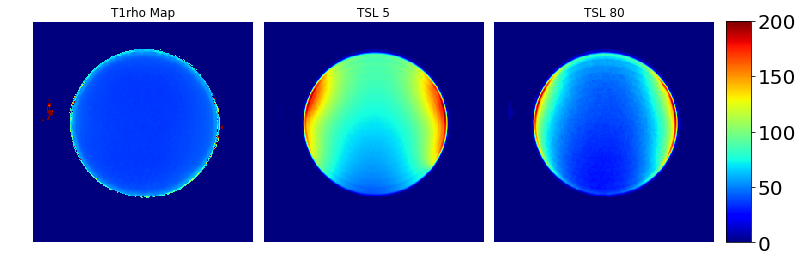

In [9]:
fig, (t1rIm, tslIm1, tslIm2) = plt.subplots(1,3, figsize=(14,14))
im1 = tslIm1.imshow(maskedTslBuffer[:,:,40,0])
im1.set_cmap('jet')
tslIm1.axis('off')
tslIm1.set_title('TSL '+str(TSLs[0]))

im2 = tslIm2.imshow(maskedTslBuffer[:,:,40,1])
im2.set_cmap('jet')
tslIm2.axis('off')
tslIm2.set_title('TSL '+str(TSLs[1]))

im3 = t1rIm.imshow(t1rMap[:,:,40])
im3.set_cmap('jet')
t1rIm.axis('off')
t1rIm.set_title('T1rho Map')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.812, 0.393, 0.025, 0.22])
fig.colorbar(im3, cax=cbar_ax)
# fig.axes[1].set_ylabel(r'\textbf{T1$\rho$ (ms)}', fontsize=25)
fig.axes[3].yaxis.set_tick_params(labelsize=20)

plt.subplots_adjust(wspace=0.05)
plt.show()